In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import time
import seaborn as sns
import plotly.express as px

<h3>Preprocessing (Loading, removing and showing graphs)</h3>

In [3]:
# Load your CSV dataset (replace 'your_dataset.csv' with your actual dataset)
data = pd.read_csv('/content/drive/MyDrive/ML/Thesis/Family_Attribution/family3.csv')
from sklearn.preprocessing import LabelEncoder
lab=LabelEncoder()
data['Class']=lab.fit_transform(data['Class'])
data['Category']=lab.fit_transform(data['Category'])
data['Family']=lab.fit_transform(data['Family'])
#data = data.drop(['Class'], axis=1)
#data = data.drop(['Category'], axis=1)
#data = data.drop(['Family'], axis=1)
#columns with 0 values
data = data.drop(['pslist.nprocs64bit'], axis=1)
data = data.drop(['handles.nport'], axis=1)
data = data.drop(['psxview.not_in_eprocess_pool'], axis=1)
data = data.drop(['psxview.not_in_eprocess_pool_false_avg'], axis=1)
data = data.drop(['svcscan.interactive_process_services'], axis=1)
data = data.drop(['callbacks.nanonymous'], axis=1)
data = data.drop(['modules.nmodules'], axis=1)
data = data.drop(['callbacks.ngeneric'], axis=1)
data = data.drop(['svcscan.fs_drivers'], axis=1)

In [4]:
data = data.drop_duplicates()

In [5]:
import pandas as pd
from scipy import stats

# Define a threshold for z-score, typically 2 or 3
z_score_threshold = 3

# Function to remove outliers based on z-score for all columns
def remove_outliers_zscore_all_columns(data, threshold):
    z_scores = stats.zscore(data)
    abs_z_scores = abs(z_scores)
    outliers = (abs_z_scores > threshold).all(axis=1)
    df_no_outliers = data[~outliers]
    return df_no_outliers

# Apply z-score outlier removal for all columns
df_no_outliers = remove_outliers_zscore_all_columns(data, z_score_threshold)

In [6]:
data = df_no_outliers

In [7]:
import numpy as np
import pandas as pd
from scipy.stats import skew
from sklearn.preprocessing import PowerTransformer

# Assuming your dataset is stored in a pandas DataFrame called 'df'

# Identify skewed features
skewness = data.apply(lambda x: skew(x))
skew_features = skewness[abs(skewness) > 0.5].index

# Apply log transformation to skewed features
#data[skew_features] = np.log1p(data[skew_features])

# Alternatively, you can use PowerTransformer for a more general approach
scaler = PowerTransformer(method='yeo-johnson', standardize=True)
data[skew_features] = scaler.fit_transform(data[skew_features].values)

# Now, your dataset has reduced skewness


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


<h3>Normalization</h3>

In [8]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# Create a Min-Max scaler instance
scaler = StandardScaler()
# Select the columns you want to scale (exclude the target variable if needed)
columns_to_scale = data.columns  # You can select specific columns here

# Fit the scaler on the selected columns and transform the data
data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])

<h3>Spliting for Training and Testing</h3>

In [9]:
# Separate features and labels
X = data.iloc[:, :-1].values  # Features
y = data.iloc[:, -1].values   # Class labels
X.shape

(30816, 48)

In [10]:
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # Encode the target labels
smote = SMOTE(random_state=42)

X_smote, y_smote = smote.fit_resample(X, y_encoded)
X_smote.shape

(38544, 48)

<h3>CNN-LSTM with 20 Epochs Implementation</h3>

100%|██████████| 20/20 [13:14<00:00, 39.71s/it]


Mean Training Accuracy: 56.17%
Mean Test Accuracy: 54.87%
Mean Training Loss: 1.0373
Mean Test Loss: 1.0790


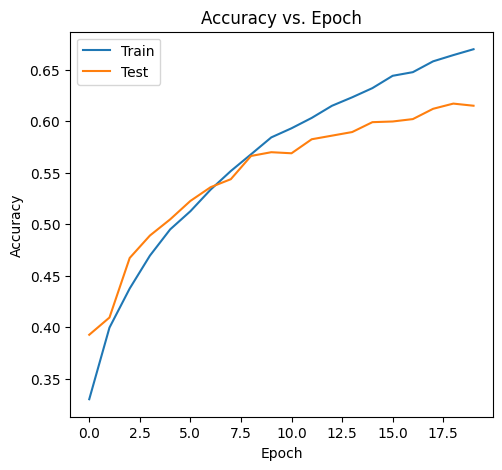

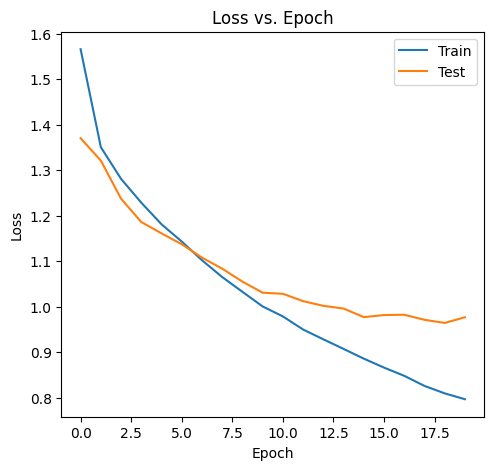

Confusion Matrix:
[[299   0   0  64   0   0  50   0   0   0   0   0   0  11  69   0]
 [  0 245   0   0  41   0   0  37  46   0   0   0  97   0   0   0]
 [  0   0 510   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [ 72   0   0 231   0   0  58   0   0   0   0   0   0  19  82   0]
 [  0  62   1   0 185   0   0  57  21   0   0   0 139   0   0   0]
 [  0   0   0   0   0 294   0   0   0  37  41  71   0   0   0  41]
 [ 55   0   0  16   0   0 363   0   0   0   0   0   0  13  49   0]
 [  0  66   0   0  52   0   0 268  31   0   0   0  64   0   0   0]
 [  0  88   0   0  40   0   0  65 215   0   0   0  67   0   0   0]
 [  0   0   0   0   0  58   0   0   0 264  96  69   0   0   0  15]
 [  0   0   0   0   0  44   0   0   0  34 334  47   0   0   0  22]
 [  0   0   0   0   0  51   0   0   0  48  43 286   0   0   0  36]
 [  0  45   0   0  46   0   0  28  28   0   0   0 354   0   0   0]
 [ 34   0   0  52   0   0  57   0   0   0   0   0   0 332  25   0]
 [ 87   0   0  87   0   0  59   0   0   0   

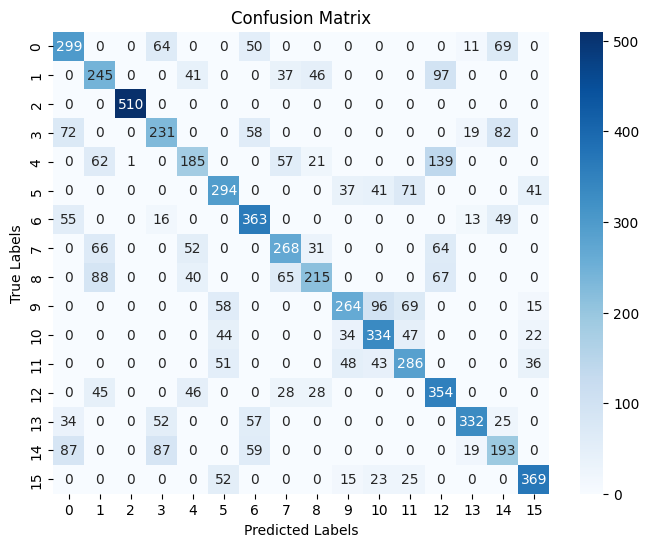

Mean Training Time: 35.96 seconds
Mean Testing Time: 3.74 seconds


In [38]:
# Convert data to PyTorch tensors
X = torch.tensor(X_smote, dtype=torch.float32)
y = torch.tensor(y_smote, dtype=torch.long)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create DataLoader for training and testing
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define a CNN-LSTM model
class CNNLSTM(nn.Module):
    def __init__(self, input_size, lstm_hidden_size, num_lstm_layers, num_classes):
        super(CNNLSTM, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
        )
        self.lstm = nn.LSTM(64, lstm_hidden_size, num_lstm_layers, batch_first=True)
        self.fc = nn.Linear(lstm_hidden_size, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add a channel dimension (batch_size, 1, input_size)
        cnn_out = self.cnn(x)
        cnn_out = cnn_out.permute(0, 2, 1)  # Reshape for LSTM (batch_size, sequence_length, channels)
        lstm_out, _ = self.lstm(cnn_out)
        lstm_out = lstm_out[:, -1, :]  # Get the last time step output
        output = self.fc(lstm_out)
        return output

# Specify the model hyperparameters
input_size = 44  # Number of input features
lstm_hidden_size = 128  # LSTM hidden layer size
num_lstm_layers = 2  # Number of LSTM layers
num_classes = len(np.unique(y_train))  # Number of classes

# Create an instance of the CNN-LSTM model
model = CNNLSTM(input_size, lstm_hidden_size, num_lstm_layers, num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
# Initialize lists to store time taken for training and testing
train_times = []
test_times = []
for epoch in tqdm(range(num_epochs)):
    model.train()
    correct_train = 0
    total_train = 0
    running_train_loss = 0.0
    start_time = time.time()  # Start time for training

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_time = time.time() - start_time  # Calculate training time
    train_times.append(train_time)

    train_accuracy = correct_train / total_train
    train_losses.append(running_train_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    # Evaluation on the test set
    model.eval()
    correct_test = 0
    total_test = 0
    running_test_loss = 0.0

    start_time = time.time()  # Start time for testing

    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

    test_time = time.time() - start_time  # Calculate testing time
    test_times.append(test_time)

    test_accuracy = correct_test / total_test
    test_losses.append(running_test_loss / len(test_loader))
    test_accuracies.append(test_accuracy)

# Calculate and display the mean accuracy
mean_train_accuracy = np.mean(train_accuracies)
mean_test_accuracy = np.mean(test_accuracies)

print(f'Mean Training Accuracy: {mean_train_accuracy * 100:.2f}%')
print(f'Mean Test Accuracy: {mean_test_accuracy * 100:.2f}%')

# Calculate and display the mean training and test loss
mean_train_loss = np.mean(train_losses)
mean_test_loss = np.mean(test_losses)

print(f'Mean Training Loss: {mean_train_loss:.4f}')
print(f'Mean Test Loss: {mean_test_loss:.4f}')
# Plot training and test accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_accuracies, label="Train")
plt.plot(range(num_epochs), test_accuracies, label="Test")
plt.title("Accuracy vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('/content/drive/MyDrive/ML/Thesis/Family_Attribution/graphs/cnn-lstm/20_epochs_accuracy.pdf', format='pdf')
plt.show()
plt.close()  # Close the figure to start a new one

# Plot training and test loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)  # Change the subplot index to 2
plt.plot(range(num_epochs), train_losses, label="Train")
plt.plot(range(num_epochs), test_losses, label="Test")
plt.title("Loss vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('/content/drive/MyDrive/ML/Thesis/Family_Attribution/graphs/cnn-lstm/20_epochs_loss.pdf', format='pdf')
plt.show()
plt.close()  # Close the figure

# Calculate and display the confusion matrix
model.eval()
all_true_labels = []
all_predicted_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_true_labels.extend(labels.cpu().numpy())
        all_predicted_labels.extend(predicted.cpu().numpy())

conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('/content/drive/MyDrive/ML/Thesis/Family_Attribution/graphs/cnn-lstm/20_epochs_confusion.pdf', format='pdf')
plt.show()
plt.close()
# Print training and testing times
print(f'Mean Training Time: {np.mean(train_times):.2f} seconds')
print(f'Mean Testing Time: {np.mean(test_times):.2f} seconds')
#This code will calculate and display the time taken for training and testing and will also visualize the confusion matrix after training.

<h3>CNN-LSTM with 30 Epochs Implementation</h3>

100%|██████████| 30/30 [19:46<00:00, 39.56s/it]


Mean Training Accuracy: 61.01%
Mean Test Accuracy: 57.36%
Mean Training Loss: 0.9296
Mean Test Loss: 1.0375


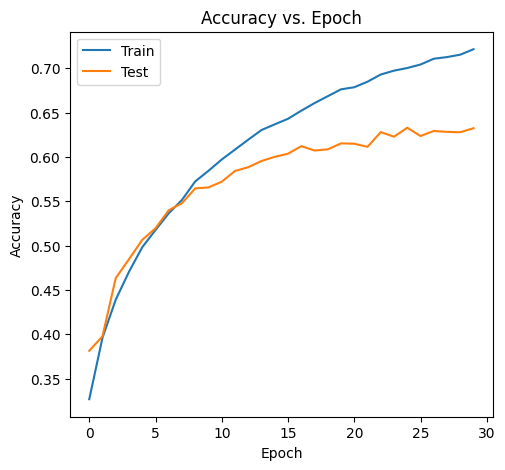

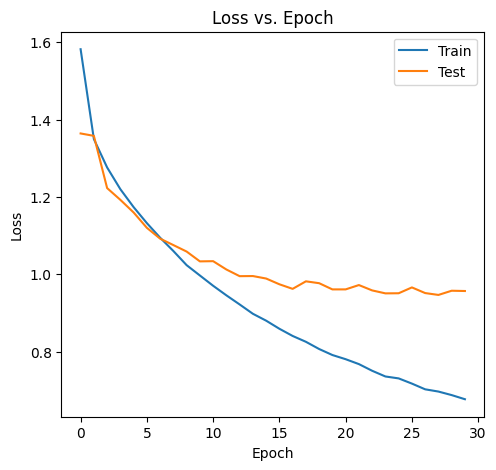

Confusion Matrix:
[[256   0   0  56   0   0  67   0   0   0   0   0   0  18  96   0]
 [  0 249   0   0  60   0   0  24  74   0   0   0  59   0   0   0]
 [  0   0 510   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [ 47   0   0 257   0   0  55   0   0   0   0   0   0  29  74   0]
 [  0  39   0   0 222   0   0  33  65   0   0   0 106   0   0   0]
 [  0   0   0   0   0 305   0   0   0  40  38  42   0   0   0  59]
 [ 35   0   0  24   0   0 367   0   0   0   0   0   0  31  39   0]
 [  0  65   0   0  61   0   0 232  91   0   0   0  32   0   0   0]
 [  0  67   0   0  55   0   0  22 289   0   0   0  42   0   0   0]
 [  0   0   0   0   0  37   0   0   0 300  99  48   0   0   0  18]
 [  0   0   0   0   0  35   0   0   0  38 357  28   0   0   0  23]
 [  0   0   0   0   0  49   0   0   0  65  45 263   0   0   0  42]
 [  0  38   0   0  81   0   0  18  59   0   0   0 305   0   0   0]
 [ 13   0   0  36   0   0  40   0   0   0   0   0   0 373  38   0]
 [ 48   0   0  94   0   0  82   0   0   0   

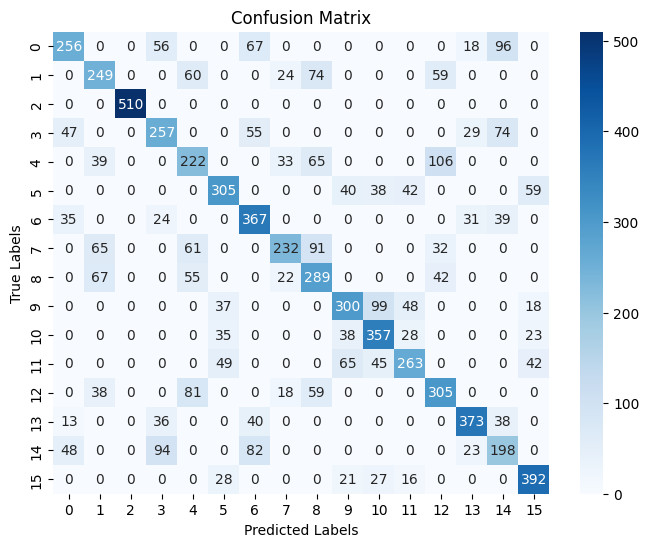

Mean Training Time: 35.73 seconds
Mean Testing Time: 3.83 seconds


In [39]:
# Convert data to PyTorch tensors
X = torch.tensor(X_smote, dtype=torch.float32)
y = torch.tensor(y_smote, dtype=torch.long)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create DataLoader for training and testing
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define a CNN-LSTM model
class CNNLSTM(nn.Module):
    def __init__(self, input_size, lstm_hidden_size, num_lstm_layers, num_classes):
        super(CNNLSTM, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
        )
        self.lstm = nn.LSTM(64, lstm_hidden_size, num_lstm_layers, batch_first=True)
        self.fc = nn.Linear(lstm_hidden_size, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add a channel dimension (batch_size, 1, input_size)
        cnn_out = self.cnn(x)
        cnn_out = cnn_out.permute(0, 2, 1)  # Reshape for LSTM (batch_size, sequence_length, channels)
        lstm_out, _ = self.lstm(cnn_out)
        lstm_out = lstm_out[:, -1, :]  # Get the last time step output
        output = self.fc(lstm_out)
        return output

# Specify the model hyperparameters
input_size = 44  # Number of input features
lstm_hidden_size = 128  # LSTM hidden layer size
num_lstm_layers = 2  # Number of LSTM layers
num_classes = len(np.unique(y_train))  # Number of classes

# Create an instance of the CNN-LSTM model
model = CNNLSTM(input_size, lstm_hidden_size, num_lstm_layers, num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 30
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
# Initialize lists to store time taken for training and testing
train_times = []
test_times = []
for epoch in tqdm(range(num_epochs)):
    model.train()
    correct_train = 0
    total_train = 0
    running_train_loss = 0.0
    start_time = time.time()  # Start time for training

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_time = time.time() - start_time  # Calculate training time
    train_times.append(train_time)

    train_accuracy = correct_train / total_train
    train_losses.append(running_train_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    # Evaluation on the test set
    model.eval()
    correct_test = 0
    total_test = 0
    running_test_loss = 0.0

    start_time = time.time()  # Start time for testing

    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

    test_time = time.time() - start_time  # Calculate testing time
    test_times.append(test_time)

    test_accuracy = correct_test / total_test
    test_losses.append(running_test_loss / len(test_loader))
    test_accuracies.append(test_accuracy)

# Calculate and display the mean accuracy
mean_train_accuracy = np.mean(train_accuracies)
mean_test_accuracy = np.mean(test_accuracies)

print(f'Mean Training Accuracy: {mean_train_accuracy * 100:.2f}%')
print(f'Mean Test Accuracy: {mean_test_accuracy * 100:.2f}%')

# Calculate and display the mean training and test loss
mean_train_loss = np.mean(train_losses)
mean_test_loss = np.mean(test_losses)

print(f'Mean Training Loss: {mean_train_loss:.4f}')
print(f'Mean Test Loss: {mean_test_loss:.4f}')
# Plot training and test accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_accuracies, label="Train")
plt.plot(range(num_epochs), test_accuracies, label="Test")
plt.title("Accuracy vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('/content/drive/MyDrive/ML/Thesis/Family_Attribution/graphs/cnn-lstm/30_epochs_accuracy.pdf', format='pdf')
plt.show()
plt.close()  # Close the figure to start a new one

# Plot training and test loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)  # Change the subplot index to 2
plt.plot(range(num_epochs), train_losses, label="Train")
plt.plot(range(num_epochs), test_losses, label="Test")
plt.title("Loss vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('/content/drive/MyDrive/ML/Thesis/Family_Attribution/graphs/cnn-lstm/30_epochs_loss.pdf', format='pdf')
plt.show()
plt.close()  # Close the figure

# Calculate and display the confusion matrix
model.eval()
all_true_labels = []
all_predicted_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_true_labels.extend(labels.cpu().numpy())
        all_predicted_labels.extend(predicted.cpu().numpy())

conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('/content/drive/MyDrive/ML/Thesis/Family_Attribution/graphs/cnn-lstm/30_epochs_confusion.pdf', format='pdf')
plt.show()
plt.close()
# Print training and testing times
print(f'Mean Training Time: {np.mean(train_times):.2f} seconds')
print(f'Mean Testing Time: {np.mean(test_times):.2f} seconds')
#This code will calculate and display the time taken for training and testing and will also visualize the confusion matrix after training.

<h3>CNN-LSTM with 50 Epochs Implementation</h3>

100%|██████████| 50/50 [33:06<00:00, 39.73s/it]


Mean Training Accuracy: 67.80%
Mean Test Accuracy: 60.91%
Mean Training Loss: 0.7737
Mean Test Loss: 1.0100


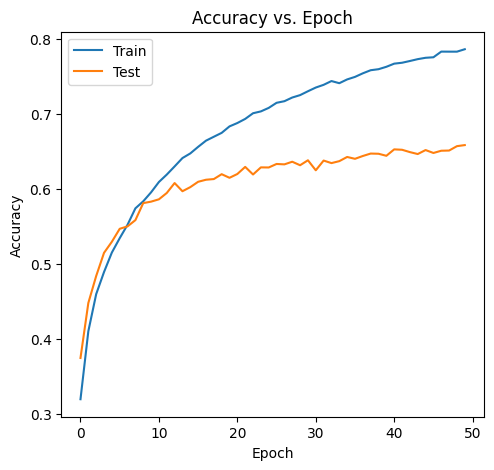

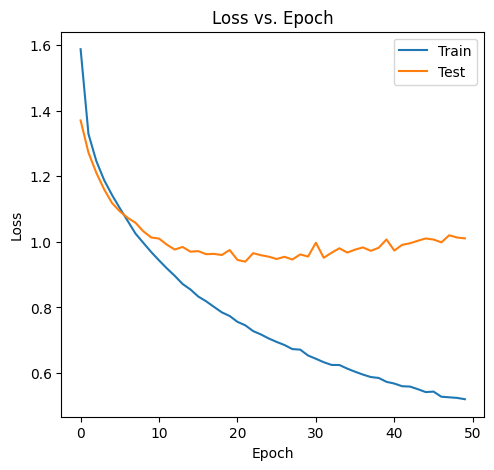

Confusion Matrix:
[[304   0   0  50   0   1  43   0   0   0   0   0   0  17  78   0]
 [  0 258   0   0  58   0   0  59  45   0   0   0  46   0   0   0]
 [  0   0 510   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [ 43   0   0 247   0   0  51   0   0   0   0   0   0  32  89   0]
 [  0  38   0   0 241   0   0  82  21   0   0   0  83   0   0   0]
 [  0   0   0   0   0 301   0   0   0  38  34  53   0   0   0  58]
 [ 44   0   0  20   0   0 359   0   0   0   0   0   0  22  51   0]
 [  0  65   0   0  52   0   0 311  26   0   0   0  27   0   0   0]
 [  0  79   0   0  56   0   0  69 235   0   0   0  36   0   0   0]
 [  0   0   0   0   0  23   0   0   0 370  51  42   1   0   0  15]
 [  0   0   0   0   0  27   0   0   0  48 350  36   0   0   0  20]
 [  0   0   0   0   0  24   0   0   0  65  34 299   0   0   0  42]
 [  0  51   0   0  83   0   0  41  34   0   0   0 292   0   0   0]
 [ 18   0   0  29   0   0  38   0   0   0   0   0   0 382  33   0]
 [ 63   0   0  80   0   0  59   0   0   0   

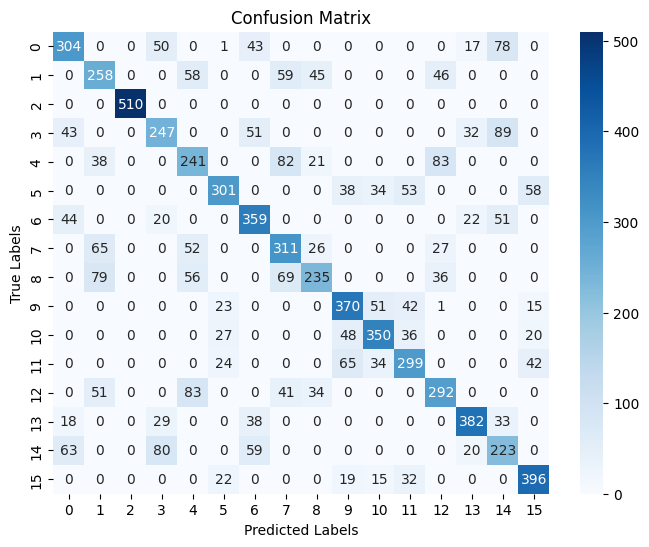

Mean Training Time: 35.81 seconds
Mean Testing Time: 3.93 seconds


In [40]:
# Convert data to PyTorch tensors
X = torch.tensor(X_smote, dtype=torch.float32)
y = torch.tensor(y_smote, dtype=torch.long)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create DataLoader for training and testing
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define a CNN-LSTM model
class CNNLSTM(nn.Module):
    def __init__(self, input_size, lstm_hidden_size, num_lstm_layers, num_classes):
        super(CNNLSTM, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
        )
        self.lstm = nn.LSTM(64, lstm_hidden_size, num_lstm_layers, batch_first=True)
        self.fc = nn.Linear(lstm_hidden_size, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add a channel dimension (batch_size, 1, input_size)
        cnn_out = self.cnn(x)
        cnn_out = cnn_out.permute(0, 2, 1)  # Reshape for LSTM (batch_size, sequence_length, channels)
        lstm_out, _ = self.lstm(cnn_out)
        lstm_out = lstm_out[:, -1, :]  # Get the last time step output
        output = self.fc(lstm_out)
        return output

# Specify the model hyperparameters
input_size = 44  # Number of input features
lstm_hidden_size = 128  # LSTM hidden layer size
num_lstm_layers = 2  # Number of LSTM layers
num_classes = len(np.unique(y_train))  # Number of classes

# Create an instance of the CNN-LSTM model
model = CNNLSTM(input_size, lstm_hidden_size, num_lstm_layers, num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
# Initialize lists to store time taken for training and testing
train_times = []
test_times = []
for epoch in tqdm(range(num_epochs)):
    model.train()
    correct_train = 0
    total_train = 0
    running_train_loss = 0.0
    start_time = time.time()  # Start time for training

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_time = time.time() - start_time  # Calculate training time
    train_times.append(train_time)

    train_accuracy = correct_train / total_train
    train_losses.append(running_train_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    # Evaluation on the test set
    model.eval()
    correct_test = 0
    total_test = 0
    running_test_loss = 0.0

    start_time = time.time()  # Start time for testing

    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

    test_time = time.time() - start_time  # Calculate testing time
    test_times.append(test_time)

    test_accuracy = correct_test / total_test
    test_losses.append(running_test_loss / len(test_loader))
    test_accuracies.append(test_accuracy)

# Calculate and display the mean accuracy
mean_train_accuracy = np.mean(train_accuracies)
mean_test_accuracy = np.mean(test_accuracies)

print(f'Mean Training Accuracy: {mean_train_accuracy * 100:.2f}%')
print(f'Mean Test Accuracy: {mean_test_accuracy * 100:.2f}%')

# Calculate and display the mean training and test loss
mean_train_loss = np.mean(train_losses)
mean_test_loss = np.mean(test_losses)

print(f'Mean Training Loss: {mean_train_loss:.4f}')
print(f'Mean Test Loss: {mean_test_loss:.4f}')
# Plot training and test accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_accuracies, label="Train")
plt.plot(range(num_epochs), test_accuracies, label="Test")
plt.title("Accuracy vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('/content/drive/MyDrive/ML/Thesis/Family_Attribution/graphs/cnn-lstm/50_epochs_accuracy.pdf', format='pdf')
plt.show()
plt.close()  # Close the figure to start a new one

# Plot training and test loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)  # Change the subplot index to 2
plt.plot(range(num_epochs), train_losses, label="Train")
plt.plot(range(num_epochs), test_losses, label="Test")
plt.title("Loss vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('/content/drive/MyDrive/ML/Thesis/Family_Attribution/graphs/cnn-lstm/50_epochs_loss.pdf', format='pdf')
plt.show()
plt.close()  # Close the figure

# Calculate and display the confusion matrix
model.eval()
all_true_labels = []
all_predicted_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_true_labels.extend(labels.cpu().numpy())
        all_predicted_labels.extend(predicted.cpu().numpy())

conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('/content/drive/MyDrive/ML/Thesis/Family_Attribution/graphs/cnn-lstm/50_epochs_confusion.pdf', format='pdf')
plt.show()
plt.close()
# Print training and testing times
print(f'Mean Training Time: {np.mean(train_times):.2f} seconds')
print(f'Mean Testing Time: {np.mean(test_times):.2f} seconds')
#This code will calculate and display the time taken for training and testing and will also visualize the confusion matrix after training.

<h3>CNN-LSTM with 100 Epochs Implementation</h3>

100%|██████████| 100/100 [1:05:52<00:00, 39.53s/it]


Mean Training Accuracy: 73.52%
Mean Test Accuracy: 62.56%
Mean Training Loss: 0.6343
Mean Test Loss: 1.0589


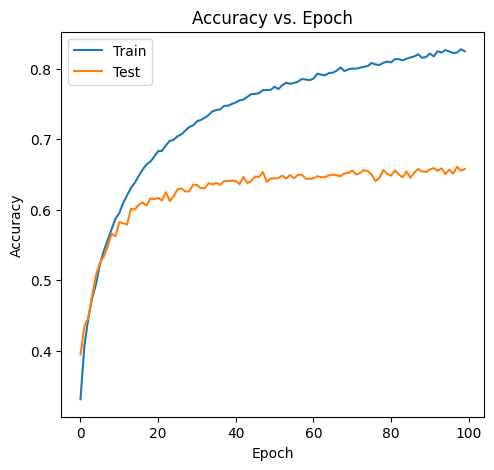

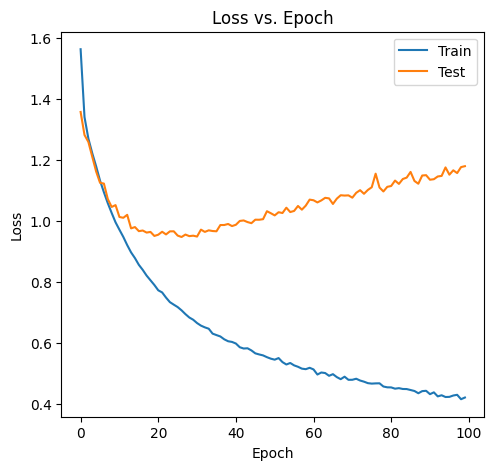

Confusion Matrix:
[[316   0   0  46   0   0  53   0   0   0   0   0   0  15  63   0]
 [  0 244   0   0  46   0   0  59  64   0   0   0  53   0   0   0]
 [  0   0 510   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [ 47   0   0 240   0   0  52   0   0   0   0   0   0  31  92   0]
 [  0  42   0   0 227   0   0  61  33   0   0   0 102   0   0   0]
 [  0   0   0   0   0 311   0   0   0  35  39  63   0   0   0  36]
 [ 45   0   0  22   0   0 370   0   0   0   0   0   0  18  41   0]
 [  0  45   0   0  44   0   0 320  41   0   0   0  31   0   0   0]
 [  0  72   0   0  40   0   0  57 276   0   0   0  30   0   0   0]
 [  0   0   0   0   0  28   0   0   0 331  85  39   0   0   0  19]
 [  0   0   0   0   0  33   0   0   0  35 355  41   0   0   0  17]
 [  0   0   0   0   0  35   0   0   0  47  59 293   0   0   0  30]
 [  0  61   0   0  48   0   0  36  35   0   0   0 321   0   0   0]
 [ 30   0   0  25   0   0  33   0   0   0   0   0   0 373  39   0]
 [ 75   0   0  86   0   0  61   0   0   0   

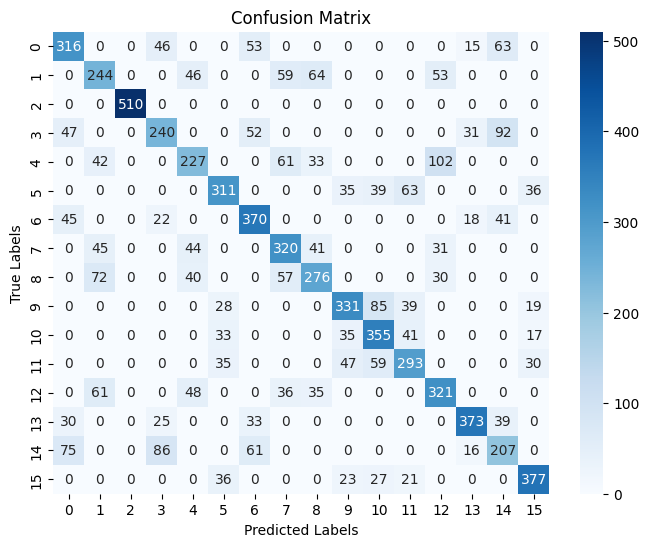

Mean Training Time: 35.70 seconds
Mean Testing Time: 3.83 seconds


In [41]:
# Convert data to PyTorch tensors
X = torch.tensor(X_smote, dtype=torch.float32)
y = torch.tensor(y_smote, dtype=torch.long)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create DataLoader for training and testing
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define a CNN-LSTM model
class CNNLSTM(nn.Module):
    def __init__(self, input_size, lstm_hidden_size, num_lstm_layers, num_classes):
        super(CNNLSTM, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
        )
        self.lstm = nn.LSTM(64, lstm_hidden_size, num_lstm_layers, batch_first=True)
        self.fc = nn.Linear(lstm_hidden_size, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add a channel dimension (batch_size, 1, input_size)
        cnn_out = self.cnn(x)
        cnn_out = cnn_out.permute(0, 2, 1)  # Reshape for LSTM (batch_size, sequence_length, channels)
        lstm_out, _ = self.lstm(cnn_out)
        lstm_out = lstm_out[:, -1, :]  # Get the last time step output
        output = self.fc(lstm_out)
        return output

# Specify the model hyperparameters
input_size = 44  # Number of input features
lstm_hidden_size = 128  # LSTM hidden layer size
num_lstm_layers = 2  # Number of LSTM layers
num_classes = len(np.unique(y_train))  # Number of classes

# Create an instance of the CNN-LSTM model
model = CNNLSTM(input_size, lstm_hidden_size, num_lstm_layers, num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
# Initialize lists to store time taken for training and testing
train_times = []
test_times = []
for epoch in tqdm(range(num_epochs)):
    model.train()
    correct_train = 0
    total_train = 0
    running_train_loss = 0.0
    start_time = time.time()  # Start time for training

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_time = time.time() - start_time  # Calculate training time
    train_times.append(train_time)

    train_accuracy = correct_train / total_train
    train_losses.append(running_train_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    # Evaluation on the test set
    model.eval()
    correct_test = 0
    total_test = 0
    running_test_loss = 0.0

    start_time = time.time()  # Start time for testing

    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

    test_time = time.time() - start_time  # Calculate testing time
    test_times.append(test_time)

    test_accuracy = correct_test / total_test
    test_losses.append(running_test_loss / len(test_loader))
    test_accuracies.append(test_accuracy)

# Calculate and display the mean accuracy
mean_train_accuracy = np.mean(train_accuracies)
mean_test_accuracy = np.mean(test_accuracies)

print(f'Mean Training Accuracy: {mean_train_accuracy * 100:.2f}%')
print(f'Mean Test Accuracy: {mean_test_accuracy * 100:.2f}%')

# Calculate and display the mean training and test loss
mean_train_loss = np.mean(train_losses)
mean_test_loss = np.mean(test_losses)

print(f'Mean Training Loss: {mean_train_loss:.4f}')
print(f'Mean Test Loss: {mean_test_loss:.4f}')
# Plot training and test accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_accuracies, label="Train")
plt.plot(range(num_epochs), test_accuracies, label="Test")
plt.title("Accuracy vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('/content/drive/MyDrive/ML/Thesis/Family_Attribution/graphs/cnn-lstm/100_epochs_accuracy.pdf', format='pdf')
plt.show()
plt.close()  # Close the figure to start a new one

# Plot training and test loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)  # Change the subplot index to 2
plt.plot(range(num_epochs), train_losses, label="Train")
plt.plot(range(num_epochs), test_losses, label="Test")
plt.title("Loss vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('/content/drive/MyDrive/ML/Thesis/Family_Attribution/graphs/cnn-lstm/100_epochs_loss.pdf', format='pdf')
plt.show()
plt.close()  # Close the figure

# Calculate and display the confusion matrix
model.eval()
all_true_labels = []
all_predicted_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_true_labels.extend(labels.cpu().numpy())
        all_predicted_labels.extend(predicted.cpu().numpy())

conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('/content/drive/MyDrive/ML/Thesis/Family_Attribution/graphs/cnn-lstm/100_epochs_confusion.pdf', format='pdf')
plt.show()
plt.close()
# Print training and testing times
print(f'Mean Training Time: {np.mean(train_times):.2f} seconds')
print(f'Mean Testing Time: {np.mean(test_times):.2f} seconds')
#This code will calculate and display the time taken for training and testing and will also visualize the confusion matrix after training.

<h3>CNN-LSTM with 150 Epochs Implementation</h3>

100%|██████████| 150/150 [2:04:42<00:00, 49.88s/it]


Mean Training Accuracy: 76.98%
Mean Test Accuracy: 63.50%
Mean Training Loss: 0.5539
Mean Test Loss: 1.1223


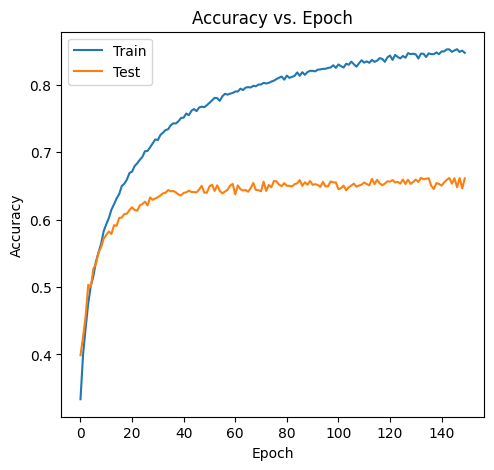

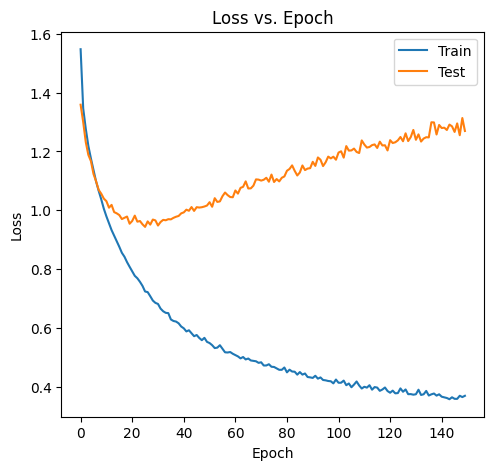

Confusion Matrix:
[[292   0   0  48   0   0  45   0   0   0   0   0   0  14  94   0]
 [  0 258   0   0  52   0   0  46  63   0   0   0  47   0   0   0]
 [  0   0 510   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [ 43   0   0 237   0   0  36   0   0   0   0   0   0  39 107   0]
 [  0  41   0   0 245   0   0  48  48   0   0   0  83   0   0   0]
 [  0   0   0   0   0 309   0   0   0  34  34  54   0   0   0  53]
 [ 34   0   0  23   0   0 365   0   0   0   0   0   0  20  54   0]
 [  0  67   0   0  49   0   0 282  55   0   0   0  28   0   0   0]
 [  0  72   0   0  46   0   0  37 282   0   0   0  38   0   0   0]
 [  0   0   0   0   0  28   0   0   0 350  45  60   0   0   0  19]
 [  0   0   0   0   0  19   0   0   0  33 358  51   0   0   0  20]
 [  0   0   0   0   0  29   0   0   0  30  43 330   0   0   0  32]
 [  0  64   0   0  70   0   0  37  54   0   0   0 276   0   0   0]
 [ 18   0   0  20   0   0  28   0   0   0   0   0   0 397  37   0]
 [ 54   0   0  87   0   0  62   0   0   0   

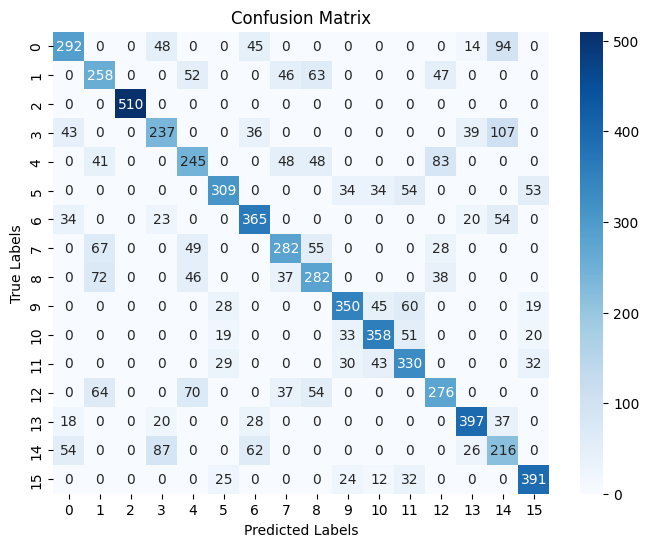

Mean Training Time: 45.13 seconds
Mean Testing Time: 4.75 seconds


In [11]:
# Convert data to PyTorch tensors
X = torch.tensor(X_smote, dtype=torch.float32)
y = torch.tensor(y_smote, dtype=torch.long)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create DataLoader for training and testing
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define a CNN-LSTM model
class CNNLSTM(nn.Module):
    def __init__(self, input_size, lstm_hidden_size, num_lstm_layers, num_classes):
        super(CNNLSTM, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
        )
        self.lstm = nn.LSTM(64, lstm_hidden_size, num_lstm_layers, batch_first=True)
        self.fc = nn.Linear(lstm_hidden_size, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add a channel dimension (batch_size, 1, input_size)
        cnn_out = self.cnn(x)
        cnn_out = cnn_out.permute(0, 2, 1)  # Reshape for LSTM (batch_size, sequence_length, channels)
        lstm_out, _ = self.lstm(cnn_out)
        lstm_out = lstm_out[:, -1, :]  # Get the last time step output
        output = self.fc(lstm_out)
        return output

# Specify the model hyperparameters
input_size = 44  # Number of input features
lstm_hidden_size = 128  # LSTM hidden layer size
num_lstm_layers = 2  # Number of LSTM layers
num_classes = len(np.unique(y_train))  # Number of classes

# Create an instance of the CNN-LSTM model
model = CNNLSTM(input_size, lstm_hidden_size, num_lstm_layers, num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 150
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
# Initialize lists to store time taken for training and testing
train_times = []
test_times = []
for epoch in tqdm(range(num_epochs)):
    model.train()
    correct_train = 0
    total_train = 0
    running_train_loss = 0.0
    start_time = time.time()  # Start time for training

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_time = time.time() - start_time  # Calculate training time
    train_times.append(train_time)

    train_accuracy = correct_train / total_train
    train_losses.append(running_train_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    # Evaluation on the test set
    model.eval()
    correct_test = 0
    total_test = 0
    running_test_loss = 0.0

    start_time = time.time()  # Start time for testing

    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

    test_time = time.time() - start_time  # Calculate testing time
    test_times.append(test_time)

    test_accuracy = correct_test / total_test
    test_losses.append(running_test_loss / len(test_loader))
    test_accuracies.append(test_accuracy)

# Calculate and display the mean accuracy
mean_train_accuracy = np.mean(train_accuracies)
mean_test_accuracy = np.mean(test_accuracies)

print(f'Mean Training Accuracy: {mean_train_accuracy * 100:.2f}%')
print(f'Mean Test Accuracy: {mean_test_accuracy * 100:.2f}%')

# Calculate and display the mean training and test loss
mean_train_loss = np.mean(train_losses)
mean_test_loss = np.mean(test_losses)

print(f'Mean Training Loss: {mean_train_loss:.4f}')
print(f'Mean Test Loss: {mean_test_loss:.4f}')
# Plot training and test accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_accuracies, label="Train")
plt.plot(range(num_epochs), test_accuracies, label="Test")
plt.title("Accuracy vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('/content/drive/MyDrive/ML/Thesis/Family_Attribution/graphs/cnn-lstm/150_epochs_accuracy.pdf', format='pdf')
plt.show()
plt.close()  # Close the figure to start a new one

# Plot training and test loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)  # Change the subplot index to 2
plt.plot(range(num_epochs), train_losses, label="Train")
plt.plot(range(num_epochs), test_losses, label="Test")
plt.title("Loss vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('/content/drive/MyDrive/ML/Thesis/Family_Attribution/graphs/cnn-lstm/150_epochs_loss.pdf', format='pdf')
plt.show()
plt.close()  # Close the figure

# Calculate and display the confusion matrix
model.eval()
all_true_labels = []
all_predicted_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_true_labels.extend(labels.cpu().numpy())
        all_predicted_labels.extend(predicted.cpu().numpy())

conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('/content/drive/MyDrive/ML/Thesis/Family_Attribution/graphs/cnn-lstm/150_epochs_confusion.pdf', format='pdf')
plt.show()
plt.close()
# Print training and testing times
print(f'Mean Training Time: {np.mean(train_times):.2f} seconds')
print(f'Mean Testing Time: {np.mean(test_times):.2f} seconds')
#This code will calculate and display the time taken for training and testing and will also visualize the confusion matrix after training.